**CMP585 - Structural Bioinformatics**

Cristian Lopes

*Assignment 1: Q3*

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Data

## Read Molecules

In [2]:
reference_path = 'data/reference.pdb'
model_paths = ['data/1ACW-0%s.pdb' % (1 + n) for n in range(6)]

In [3]:
def read_molecule(path):
    atoms = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('ATOM'):
                atoms.append({'atom_name': line[12:16].strip(), 
                             'residue_name': line[17:20].strip(),
                             'residue_seq_number': line[22:26].strip(),
                             'x': float(line[30:38].strip()), 
                             'y': float(line[38:46].strip()),
                             'z': float(line[46:54].strip())})
    return pd.DataFrame(atoms)

## Reference Molecule

In [4]:
reference_molecule = read_molecule(reference_path).iloc[:410]

In [5]:
reference_molecule.head()

,atom_name,residue_name,residue_seq_number,x,y,z
0,N,VAL,1,0.965,0.298,-0.467
1,CA,VAL,1,1.811,0.250,-1.701
2,C,VAL,1,3.290,0.400,-1.320
3,O,VAL,1,3.628,1.053,-0.346
4,CB,VAL,1,1.417,1.384,-2.664


## Model Molecules

In [6]:
model_molecules = [read_molecule(path) for path in model_paths]

In [7]:
model_molecules[0].head()

,atom_name,residue_name,residue_seq_number,x,y,z
0,N,VAL,1,-1.352,-2.044,0.000
1,H1,VAL,1,-1.990,-1.261,0.000
2,H2,VAL,1,-1.446,-2.540,0.875
3,H3,VAL,1,-1.446,-2.540,-0.875
4,CA,VAL,1,0.000,-1.523,0.000


# Calculate RMSD for translated molecules

## Define translation

In [8]:
def calculate_translation(ref_atom, model_atom):
    return ref_atom[['x', 'y', 'z']] - model_atom[['x', 'y', 'z']]

def translate_molecule_to_new_reference(ref_molecule, model_molecule, translation): 
    translated_model_molecule = model_molecule.copy()
    translated_model_molecule['x'] = model_molecule['x'] + translation['x']
    translated_model_molecule['y'] = model_molecule['y'] + translation['y']
    translated_model_molecule['z'] = model_molecule['z'] + translation['z']
    
    return translated_model_molecule

## Define RMSD

In [9]:
def molecules_rmsd(ref_molecule, model_molecule):
    molecules_df = pd.merge(ref_molecule, model_molecule, on=['residue_seq_number', 'atom_name'])
    
    molecules_df['x_distance_squared'] = (molecules_df['x_x'] - molecules_df['x_y']) ** 2
    molecules_df['y_distance_squared'] = (molecules_df['y_x'] - molecules_df['y_y']) ** 2
    molecules_df['z_distance_squared'] = (molecules_df['z_x'] - molecules_df['z_y']) ** 2
    
    molecules_df['euclidean_distance_squared'] = (molecules_df['x_distance_squared'] + 
                                                  molecules_df['y_distance_squared'] +
                                                  molecules_df['z_distance_squared'])
    
    return np.sqrt(np.mean(molecules_df['euclidean_distance_squared']))

# Genetic Algorithm

## Genetic Algorithm Step by Step

In [10]:
model_molecule = model_molecules[0]

### Initialization

In [11]:
DIM_POPULATION = 3
N_POPULATION = 10

In [12]:
def initialize_population(reference_molecule, model_molecule):
    # This method considers the first Alpha Carbon as system reference
    ref_system_ref = reference_molecule[reference_molecule.atom_name == 'CA'].iloc[0]
    molecule_system_ref = model_molecule[model_molecule.atom_name == 'CA'].iloc[0]

    initial_magnitude = calculate_translation(ref_system_ref, molecule_system_ref)
    initial_population = [initial_magnitude * np.random.uniform(-1, 1, DIM_POPULATION)
                          for _ in range(N_POPULATION)]

    return initial_population

In [13]:
initial_population = initialize_population(reference_molecule, model_molecule)

In [14]:
pd.DataFrame(initial_population)

,x,y,z
0,0.434513,-0.115720,0.327993
1,1.662911,1.577783,-0.284802
2,1.545784,-0.038291,-1.656660
3,0.754873,-0.238129,1.266446
4,1.016844,0.268360,0.153281
5,1.438225,-0.447840,0.569206
6,0.363273,-0.052543,-0.007260
7,-0.479620,1.095988,1.029946
8,-1.724148,1.075482,1.242102
9,-1.380680,0.163533,1.155739


### Fitness Function

In [15]:
def individual_fitness(reference_molecule, model_molecule, translation, atoms=['C', 'N', 'O']):
    translated_model_molecule = translate_molecule_to_new_reference(reference_molecule, model_molecule, translation)
    
    # Selecting atoms of interest
    reference_molecule_filtered = reference_molecule[reference_molecule.atom_name.isin(atoms)]
    translated_model_molecule_filtered = translated_model_molecule[translated_model_molecule.atom_name.isin(atoms)]

    return molecules_rmsd(reference_molecule_filtered, translated_model_molecule_filtered)

In [16]:
population = initial_population

fitness = [individual_fitness(reference_molecule, model_molecule, individual) 
                      for individual in population]

In [17]:
pd.DataFrame(fitness, columns=['fitness'])

,fitness
0,23.444922
1,22.673409
2,24.196746
3,23.111414
4,23.241349
5,23.451779
6,23.557157
7,22.599677
8,22.753561
9,23.226601


### Selection

In [18]:
def fitness_proportionate_selection(population, fitness):
    probabilities = (np.max(fitness) - fitness) / np.sum(np.max(fitness) - fitness)
    idx = np.random.choice(N_POPULATION, replace=True, p=probabilities)
    
    return population[idx]

In [19]:
parent = fitness_proportionate_selection(population, fitness)

In [20]:
pd.DataFrame(parent)

,0
x,1.66291
y,1.57778
z,-0.284802


### Crossover

In [21]:
def intermediate_recombination(population, fitness):
    p = 0.1
    alpha = np.random.uniform(-p, 1+p)
    beta = np.random.uniform(-p, 1+p)
    
    parent_1 = fitness_proportionate_selection(population, fitness)
    parent_2 = fitness_proportionate_selection(population, fitness)
    
    children_1 = alpha * parent_1 + (1 - alpha) * parent_2
    children_2 = beta * parent_1 + (1 - beta) * parent_2   
    
    return [children_1, children_2]

In [22]:
childrens = intermediate_recombination(population, fitness)

In [23]:
pd.DataFrame(childrens)

,x,y,z
0,0.453479,-0.095293,0.286140
1,0.708746,-0.216269,1.116415


### Mutation

In [24]:
def gaussian_convolution(children):
    p = np.random.rand(DIM_POPULATION)
    sigma = 1
    noise = np.random.randn(DIM_POPULATION)
    
    return children + noise * (p > 0.5)

In [25]:
mutated_children = gaussian_convolution(childrens[0])

In [26]:
pd.DataFrame(population)

,x,y,z
0,0.434513,-0.115720,0.327993
1,1.662911,1.577783,-0.284802
2,1.545784,-0.038291,-1.656660
3,0.754873,-0.238129,1.266446
4,1.016844,0.268360,0.153281
5,1.438225,-0.447840,0.569206
6,0.363273,-0.052543,-0.007260
7,-0.479620,1.095988,1.029946
8,-1.724148,1.075482,1.242102
9,-1.380680,0.163533,1.155739


## Genetic Algorithm Implementation

In [27]:
class GeneticAlgorithm:
    def __init__(self, dim_populaton, n_population, ref_molecule, molecule, atoms):
        self.DIM_POPULATION = 3
        self.N_POPULATION = 30

        self.ref_molecule = ref_molecule
        self.molecule = molecule
        self.atoms = atoms

        self.population = self.initialize_population()
        self.fitness = self.compute_population_fitness()
        self.previous_fitness = None
        
        self.iteration = 0

    def compute_translation(self, ref_atom, atom):
        return ref_atom[['x', 'y', 'z']] - atom[['x', 'y', 'z']]

    def translate_molecule_to_new_reference(self, ref_molecule, molecule, translation):
        translated_molecule = molecule.copy()
        translated_molecule['x'] = molecule['x'] + translation['x']
        translated_molecule['y'] = molecule['y'] + translation['y']
        translated_molecule['z'] = molecule['z'] + translation['z']

        return translated_molecule

    def compute_rmsd(self, ref_molecule, molecule):
        molecules_df = pd.merge(ref_molecule, molecule, on=['residue_seq_number', 'atom_name'])

        molecules_df['x_distance_squared'] = (molecules_df['x_x'] - molecules_df['x_y']) ** 2
        molecules_df['y_distance_squared'] = (molecules_df['y_x'] - molecules_df['y_y']) ** 2
        molecules_df['z_distance_squared'] = (molecules_df['z_x'] - molecules_df['z_y']) ** 2

        molecules_df['euclidean_distance_squared'] = (molecules_df['x_distance_squared'] +
                                                      molecules_df['y_distance_squared'] +
                                                      molecules_df['z_distance_squared'])

        return np.sqrt(np.mean(molecules_df['euclidean_distance_squared']))
    
    # Initialization
    def initialize_population(self):
        # This method considers the first Alpha Carbon as system reference
        ref_system_ref = self.ref_molecule[self.ref_molecule.atom_name == 'CA'].iloc[0]
        molecule_system_ref = self.molecule[self.molecule.atom_name == 'CA'].iloc[0]

        initial_magnitude = self.compute_translation(ref_system_ref, molecule_system_ref)
        initial_population = [initial_magnitude * np.random.uniform(-1, 1, self.DIM_POPULATION)
                              for _ in range(self.N_POPULATION)]

        return initial_population
    
    def generate_new_population(self):
        new_population = []
        for _ in range(self.N_POPULATION // 2):
            childrens = self.intermediate_recombination()
            new_population.extend([self.gaussian_convolution(children) for children in childrens])

        return new_population

    # Fitness
    def individual_fitness(self, translation):
        translated_molecule = self.translate_molecule_to_new_reference(self.ref_molecule, self.molecule, translation)

        # Selecting atoms of interest
        ref_molecule_filtered = self.ref_molecule[self.ref_molecule.atom_name.isin(self.atoms)]
        translated_molecule_filtered = translated_molecule[translated_molecule.atom_name.isin(self.atoms)]

        return self.compute_rmsd(ref_molecule_filtered, translated_molecule_filtered)

    def compute_population_fitness(self):
        return [self.individual_fitness(individual)
                for individual in self.population]


    # Selection
    def fitness_proportionate_selection(self):
        probabilities = (np.max(self.fitness) - self.fitness) / np.sum(np.max(self.fitness) - self.fitness)
        idx = np.random.choice(self.N_POPULATION, replace=True, p=probabilities)

        return self.population[idx]

    # Crossover
    def intermediate_recombination(self):
        p = 0.1
        alpha = np.random.uniform(-p, 1+p)
        beta = np.random.uniform(-p, 1+p)

        parent_1 = self.fitness_proportionate_selection()
        parent_2 = self.fitness_proportionate_selection()

        children_1 = alpha * parent_1 + (1 - alpha) * parent_2
        children_2 = beta * parent_1 + (1 - beta) * parent_2

        return [children_1, children_2]

    # Mutation
    def gaussian_convolution(self, children):
        add_noise_prob = np.random.rand(self.DIM_POPULATION)
        
        sigma = 0.2
        noise = sigma * np.random.randn(self.DIM_POPULATION)

        return children + noise * (add_noise_prob > 0.5)

    def done(self, epsilon, max_iteration):
        converged = (np.abs(np.mean(self.fitness) - np.mean(self.previous_fitness)) < epsilon) \
                     if self.previous_fitness is not None else False
        taking_too_long = self.iteration > max_iteration
        
        return converged or taking_too_long
        
    def optimize(self):
        average_fitness = []
        
        while not self.done(epsilon=1e-4, max_iteration=400):
            self.iteration += 1
            self.previous_fitness = self.fitness
        
            self.population = self.generate_new_population()
            self.fitness = self.compute_population_fitness()
            
            average_fitness.append(np.mean(self.fitness))
            
        print('Optimal Solution:')
        display(pd.DataFrame(self.population[np.argmin(self.fitness)]))
        print('Optimized RMSD: %.2f' % np.min(self.fitness))
        
        plt.figure()
        plt.title('Average Fitness Convergence.')
        plt.plot(average_fitness)
        plt.show()

# Q3 - a) Backbone

In [28]:
atoms = ['C', 'N', 'O']

Optimizing RMSD for molecule 1...
Optimal Solution:


,0
x,3.0493
y,13.4315
z,10.0226


Optimized RMSD: 16.30


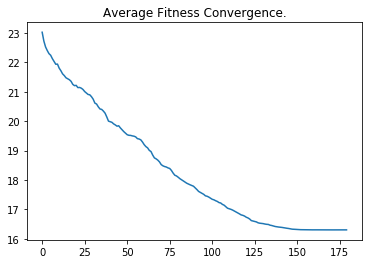

Optimizing RMSD for molecule 2...
Optimal Solution:


,0
x,29.548
y,1.91846
z,-8.60668


Optimized RMSD: 18.42


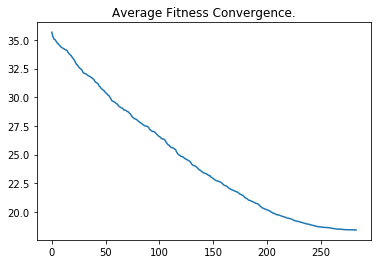

Optimizing RMSD for molecule 3...
Optimal Solution:


,0
x,9.64154
y,-10.4519
z,7.61933


Optimized RMSD: 17.37


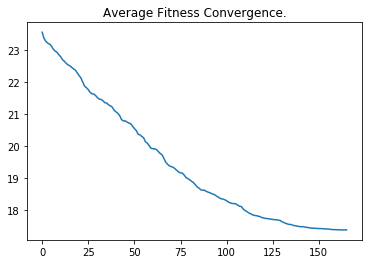

Optimizing RMSD for molecule 4...
Optimal Solution:


,0
x,-2.6766
y,9.94395
z,-8.15172


Optimized RMSD: 16.19


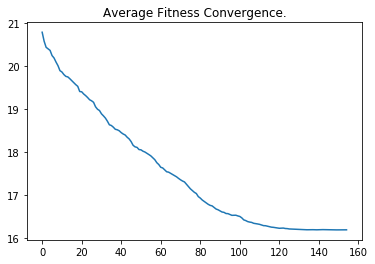

Optimizing RMSD for molecule 5...
Optimal Solution:


,0
x,-3.24295
y,-15.1803
z,-3.40587


Optimized RMSD: 15.48


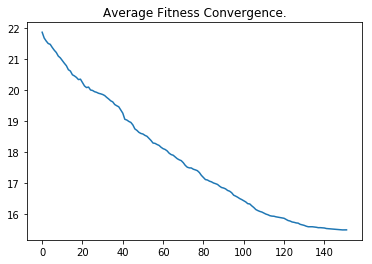

Optimizing RMSD for molecule 6...
Optimal Solution:


,0
x,1.69938
y,6.97678
z,16.0629


Optimized RMSD: 18.42


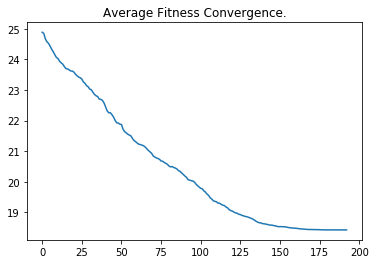

In [29]:
for i, model_molecule in enumerate(model_molecules):
    genetic_algorithm = GeneticAlgorithm(DIM_POPULATION, N_POPULATION, reference_molecule, model_molecule, atoms)
    
    print('Optimizing RMSD for molecule %d...' % (i + 1))
    genetic_algorithm.optimize()

# Q3 - b) Alpha Carbon

In [30]:
atoms = ['CA']

Optimizing RMSD for molecule 1...
Optimal Solution:


,0
x,2.94969
y,13.2537
z,9.9188


Optimized RMSD: 16.50


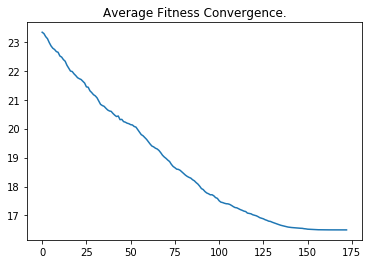

Optimizing RMSD for molecule 2...
Optimal Solution:


,0
x,20.3051
y,1.79831
z,-5.6052


Optimized RMSD: 20.73


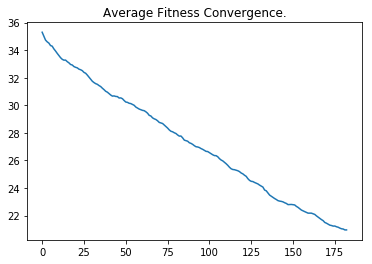

Optimizing RMSD for molecule 3...
Optimal Solution:


,0
x,9.30157
y,-10.2689
z,7.68382


Optimized RMSD: 17.31


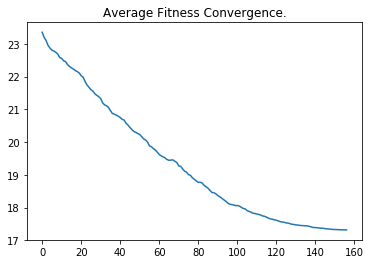

Optimizing RMSD for molecule 4...
Optimal Solution:


,0
x,-2.61947
y,9.81597
z,-7.98744


Optimized RMSD: 16.27


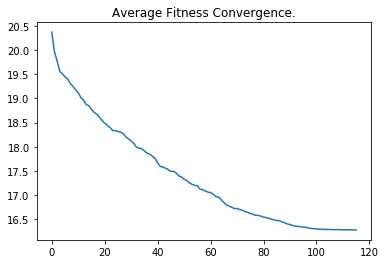

Optimizing RMSD for molecule 5...
Optimal Solution:


,0
x,-3.37566
y,-15.1179
z,-3.59668


Optimized RMSD: 15.33


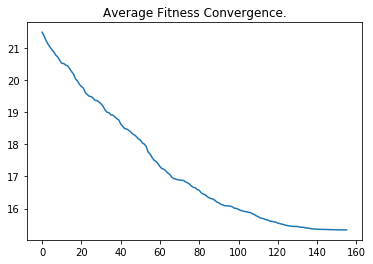

Optimizing RMSD for molecule 6...
Optimal Solution:


,0
x,1.57408
y,6.62003
z,15.9057


Optimized RMSD: 18.51


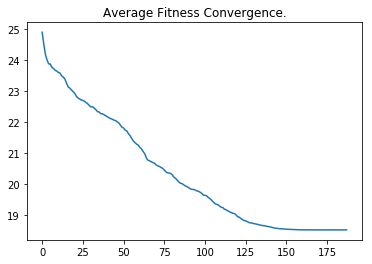

In [31]:
for i, model_molecule in enumerate(model_molecules):
    genetic_algorithm = GeneticAlgorithm(DIM_POPULATION, N_POPULATION, reference_molecule, model_molecule, atoms)
    
    print('Optimizing RMSD for molecule %d...' % (i + 1))
    genetic_algorithm.optimize()

# Q3 - c) Polypeptide

In [32]:
atoms = ['C', 'N', 'O', 'H']

Optimizing RMSD for molecule 1...
Optimal Solution:


,0
x,2.90887
y,13.311
z,10.0245


Optimized RMSD: 16.31


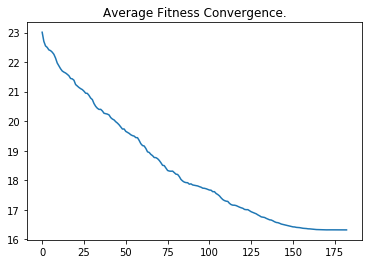

Optimizing RMSD for molecule 2...
Optimal Solution:


,0
x,29.2318
y,2.13816
z,-8.33831


Optimized RMSD: 18.15


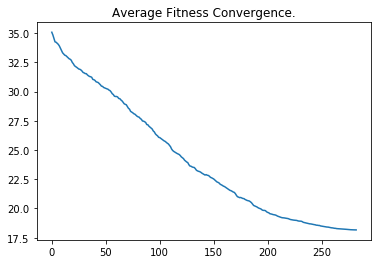

Optimizing RMSD for molecule 3...
Optimal Solution:


,0
x,9.53781
y,-10.3308
z,7.92006


Optimized RMSD: 17.28


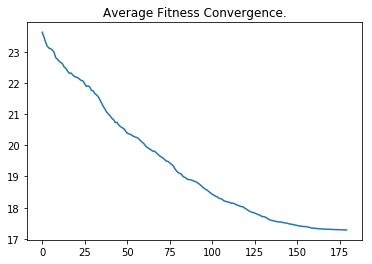

Optimizing RMSD for molecule 4...
Optimal Solution:


,0
x,-2.81837
y,9.88264
z,-8.27072


Optimized RMSD: 16.22


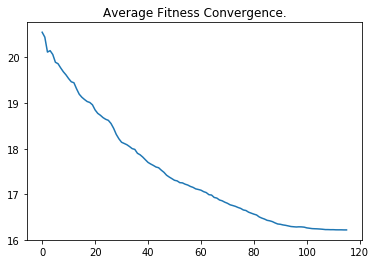

Optimizing RMSD for molecule 5...
Optimal Solution:


,0
x,-3.34274
y,-15.3691
z,-3.4399


Optimized RMSD: 15.29


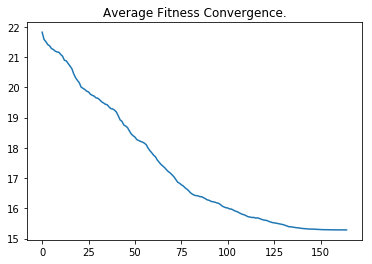

Optimizing RMSD for molecule 6...
Optimal Solution:


,0
x,1.54404
y,6.68702
z,15.9706


Optimized RMSD: 18.35


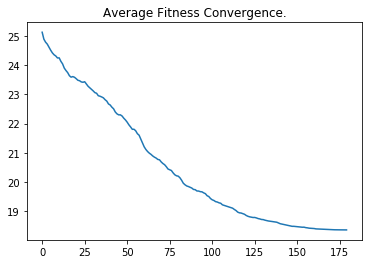

In [33]:
for i, model_molecule in enumerate(model_molecules):
    genetic_algorithm = GeneticAlgorithm(DIM_POPULATION, N_POPULATION, reference_molecule, model_molecule, atoms)
    
    print('Optimizing RMSD for molecule %d...' % (i + 1))
    genetic_algorithm.optimize()

Done!